In [20]:
from concurrent.futures import ThreadPoolExecutor
from IPython.display import display, clear_output
import math
from math import sin, cos
from matplotlib import pyplot as plt
import numpy as np
import time
from PIL import Image
import vapory

In [2]:
def create_scene(grad_deg, X):
    angle = 2 * math.pi * grad_deg / 360
    r_camera = 10
    camera = vapory.Camera('location', [r_camera * math.cos(angle), 1.5, r_camera * math.sin(angle)], 
                           'look_at', [0.0, 0.0, 0.0], 
                           'angle', 30)
    light1 = vapory.LightSource([2, 4, -3], 'color', [1, 1, 1], 'shadowless')
    light2 = vapory.LightSource([2, 4, 3], 'color', [1, 1, 1], 'shadowless')
    plane = vapory.Plane([0, 1, 0], -2, vapory.Pigment('color', [1, 1, 1]))
    box = vapory.Box([-1, -1, -1], [1, 1, 1], 
                     vapory.Pigment('Col_Glass_Clear'),
                     vapory.Finish('F_Glass9'),
                     vapory.Interior('I_Glass1'))
    spheres = [vapory.Sphere( [r[0], r[2], r[1]], 0.05, vapory.Texture(vapory.Pigment('color', [0.7, 0.7, 0]))) for r in X]
    return vapory.Scene(camera, objects=[light1, light2, plane] + spheres, included=['glass.inc'])

In [9]:
class MovieMaker:
    def __init__(self, n, width, height, x):
        self.n = n
        self.x = x
        self.rotate_angle = 360 / n
        self.ds = np.zeros((n, height, width, 3), dtype=np.uint8)    
        self.width, self.height = width, height

    def __call__(self, ind):        
        scene = create_scene(self.rotate_angle * ind, X=self.x)
        pic = scene.render(width=self.width, height=self.height)
        self.ds[ind] = pic        
        
    def shoot(self):
        with ThreadPoolExecutor(10) as p:
            p.map(self, range(self.n))

In [10]:
def get_vertice(upper, ind):
    dphi = 2 * math.pi / 5
    s = 1 if upper else -1
    dphi2 = 0 if upper else dphi / 2
    theta = math.asin((1 + cos(dphi)) / math.sqrt(2)) + 3 * math.pi / 4
    return np.array([[cos(theta)*cos(dphi*ind + dphi2), cos(theta)*sin(dphi*ind + dphi2), s * sin(theta)]])

In [11]:
def ico_vertices():
    l0 = np.array([0, 0, 1])
    l1 = np.vstack([get_vertice(True, ind) for ind in range(5)])
    l2 = np.vstack([get_vertice(False, ind) for ind in range(5)])
    l3 = np.array([0, 0, -1])
    return np.vstack([l0, l1, l2, l3])

In [18]:
mm = MovieMaker(100, width=600, height=400, x=ico_vertices())
mm.shoot()

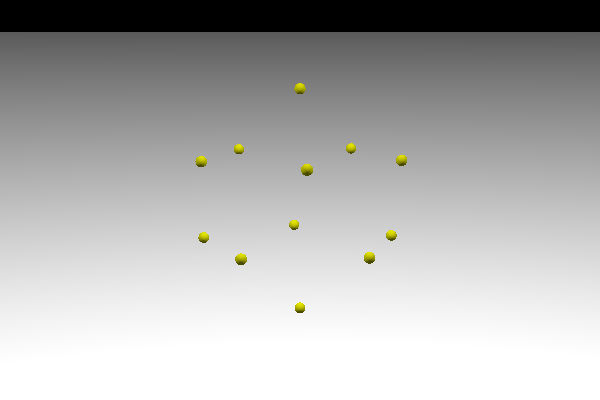

In [23]:
for picture in mm.ds:
    clear_output()
    display(Image.fromarray(picture))
    time.sleep(0.1)    